# **Hotspot tutorial: Spatial data from Slide-seq**

In this tutorial, we show how to use the optimized version of the Hotspot algorithm implemented inside Harreman by using one of the datasets used in the [original Hotspot tutorial](https://hotspot.readthedocs.io/en/latest/Spatial_Tutorial.html): the spatial data from the Slide-seq paper (Rodriques et al., *Science*, 2019).

In this tutorial we will cover:

1. Computing Autocorrelation in Hotspot to identify spatial genes.
2. Computing local correlations between spatial genes to identify modules.
3. Plotting modules, correlations, and module scores.

In [1]:
import harreman
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import mplscience
from scipy.stats import pearsonr, spearmanr, gaussian_kde
import random
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

## Defining the parametric vs non-parametric test function

To compare the results obtained from both the parametric and non-parametric tests, the function below has been defined.

In [2]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = pearsonr(x, y)
    if method == 'spearman':
        score = spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        # c_score = np.log2(z[idx] + color_rate * np.min(z[idx]))
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()
    # plt.scatter(x[idx2], y[idx2], c=outlier_color, edgecolor=None, s=size / 5,
    #             alpha=alpha / 3.0)

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Loading the dataset

In [3]:
url = "https://github.com/YosefLab/scVI-data/blob/master/rodriques_slideseq.h5ad?raw=true"
adata = sc.read("rodriques_slideseq.h5ad", backup_url=url)
adata.obs["total_counts"] = np.asarray(adata.X.sum(1)).ravel()

adata.layers["csc_counts"] = adata.X.tocsc()

# renormalize the data for expression viz on plots
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.obsm['spatial'] = np.array(adata.obsm['spatial'])

## Computing the proximity graph

In [4]:
harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial", 
                           n_neighbors=300,
                           weighted_graph=False,
                           verbose=True)

Computing the neighborhood graph...
Computing the weights...
Finished computing the KNN graph in 3.312 seconds


## Computing gene autocorrelation to determine genes with spatial variation

In [5]:
harreman.hs.compute_local_autocorrelation(adata, layer_key="csc_counts", model='bernoulli', species='mouse', umi_counts_obs_key="total_counts", permutation_test=True)

Permutation test: 100%|██████████| 1000/1000 [23:18<00:00,  1.40s/it]


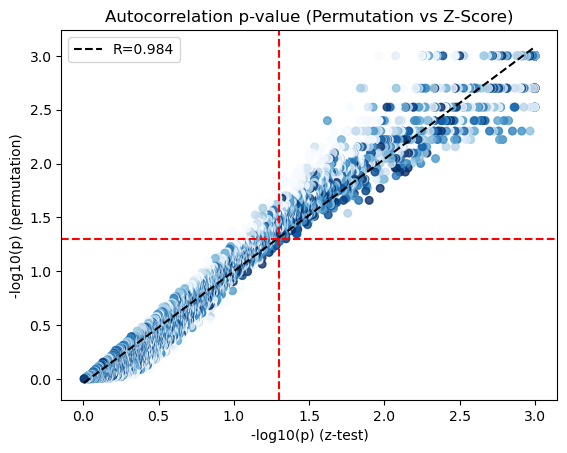

In [8]:
x = -np.log10(adata.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata.uns['gene_autocorrelation_results'].index

X = adata[:,genes].X.tocsc()
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=True, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')

In [9]:
hs_results = adata.uns['gene_autocorrelation_results']
hs_genes = hs_results.index[hs_results.Z_FDR < 0.05]

## Computing local correlation to group genes into spatial modules

In [10]:
# harreman.hs.compute_local_correlation(adata, genes=hs_genes)
harreman.hs.compute_local_correlation(adata, genes=hs_genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 876 features...


Permutation test: 100%|██████████| 1000/1000 [10:27<00:00,  1.59it/s]


Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 630.758 seconds


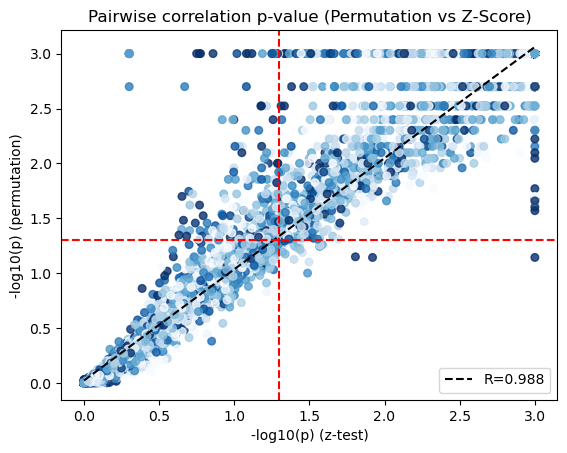

In [12]:
# global consistency
x = -np.log10(adata.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata.uns['lc_perm_pvals'].values).flatten()

genes = adata.uns['lc_z_pvals'].index
# mean_expr = adata[:,genes].X.mean(axis=0).A1

X = adata[:,genes].X.tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')

In [13]:
harreman.hs.create_modules(adata, min_gene_threshold=20, core_only=False, fdr_threshold=0.05)

## Plotting module correlations

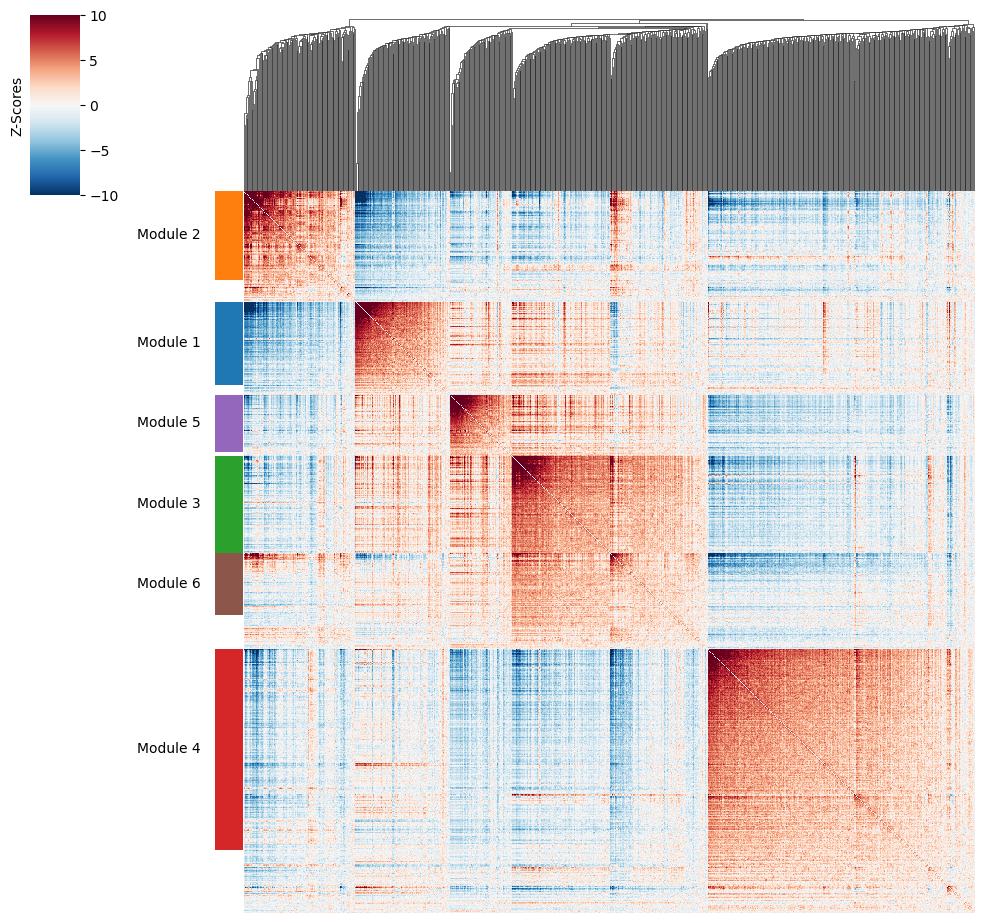

In [14]:
harreman.pl.local_correlation_plot(adata)

## Calculating module scores and visualizing them

In [15]:
harreman.hs.calculate_module_scores(adata)

100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [16]:
modules = adata.obsm['module_scores'].columns
adata.obs[modules] = adata.obsm['module_scores']

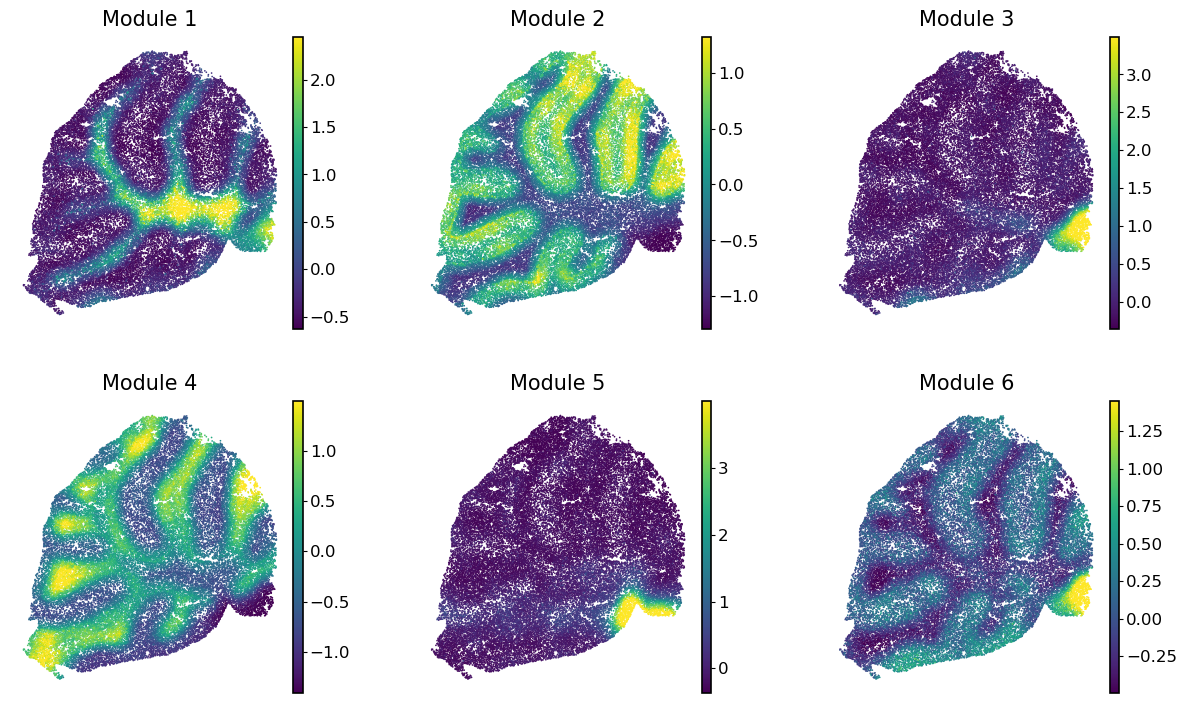

In [18]:
with mplscience.style_context():
    sc.pl.spatial(adata, color=modules, frameon=False, vmin="p1", vmax="p99", spot_size=30, ncols=3, cmap='viridis')